In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    # !wandb login
    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews
    !pip install -U ipykernel
    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on colab
/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from six.moves import xrange
import datetime
import gc
import pandas as pd
import joypy

from scipy import signal
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

from sklearn.manifold import TSNE

import pickle as pkl

In [3]:
model_name = "AE_batch_size_56_num_hiddens_64__day_17_hour_0_final.pth"
config = torch.load(f'Models/config_{model_name}')
model = AE(num_hiddens=config["num_hiddens"]).to(device)
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas_new.pth')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas_new.pth')
model.load_state_dict(torch.load(f'Models/{model_name}', map_location=torch.device('cpu')))

y = torch.load("Features/training_labels_list.pth",  map_location=torch.device('cpu'))
X = torch.load("Features/training_samples_list_torch.pth",  map_location=torch.device('cpu'))
X = X[0:6000]
y["recorder"] = y["recorder"][0:6000]

scaler = StandardScaler().fit(X)
X_n = X
X_scaled = scaler.transform(X)
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_scaled)

In [4]:
training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

## **Batch Clustering**

In [ ]:
clusters = [3, 4, 5, 6, 7, 8, 9, 10, 15, 18, 20, 25, 30 ]
for n_cluster in clusters:
    print(f"current cluster: {n_cluster}")
    iterator_Dataset = iter(training_loader)
    testing = TestModel(model, iterator_Dataset, device=torch.device("cuda"))
    Clustering = AE_Clustering(testing, training_loader, n_clusters=n_cluster)
    kmeans = Clustering.fordward()
    # Clustering.plot_centroids()
    output.clear()

current cluster: 15
id: 1 of 61
0.40403694
id: 2 of 61
0.31466037
id: 3 of 61
0.353792
id: 4 of 61
0.28293934
id: 5 of 61
0.35939232
id: 6 of 61
0.18747751
id: 7 of 61
0.32559177
id: 8 of 61
0.35349932
id: 9 of 61
0.2536019
id: 10 of 61
0.264792
id: 11 of 61
0.24244937
id: 12 of 61
0.23397636
id: 13 of 61
0.3781557
id: 14 of 61
0.18831782
id: 15 of 61
0.2973873
id: 16 of 61
0.2784652
id: 17 of 61
0.21156831
id: 18 of 61
0.26021445
id: 19 of 61
0.22631651
id: 20 of 61
0.28784692
id: 21 of 61
0.22887346
id: 22 of 61
0.2866979
id: 23 of 61
0.32924688
id: 24 of 61
0.2370078
id: 25 of 61
0.27609554
id: 26 of 61
0.25642535
id: 27 of 61
0.28842217
id: 28 of 61
0.35134736
id: 29 of 61
0.29739526


In [ ]:
Clustering.plot_centroids()
plt.savefig(f"Clustering_Results/Figures/Clustering_centroids_TSNE_7.pdf", format="pdf")

## **Traditional clustering**

In [5]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm

# Single methods
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples

In [33]:
from logging import raiseExceptions
def plot_silhouette( X, cluster_labels, n_clusters, silhouette_avg, method, extra=""):
    fig, ax1 = plt.subplots(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    print("Ya debio plotear")
    #plt.savefig(f"Clustering_Results/{method}/Figures/Silhouette_plot_{n_clusters}.pdf", format="pdf")
    #plt.show()

def plot_centroids(cluster_centers, testing, method, extra=""):
    plt.figure(figsize=(18, 18))
    testing._model.to("cpu")
    for i, spec in enumerate(cluster_centers):
        encodings = spec.reshape(64,9,9)
        encodings = torch.tensor(encodings).float()
        decodings = testing._model.decoder(encodings).detach().numpy()
        plt.subplot(6, 6, i + 1)
        plt.imshow(decodings[0, :, :], origin="lower", cmap="viridis")
        plt.xticks(())
        plt.yticks(())
    n_cluster = len(cluster_centers)
    #plt.savefig(f"Clustering_Results/{method}/Figures/Centroids_plot_{n_cluster}_{extra}.pdf", format="pdf")
    #plt.show()

import math

def num_rows_cols(num_elements):
    num_rows = int(math.sqrt(num_elements))
    num_cols = (num_elements + num_rows - 1) // num_rows
    return (num_rows, num_cols)

def get_row_col(pos, cols):
    row = pos // cols
    col = pos % cols
    return row, col

class Clustering_Results:
    def __init__(self, model, y, y_label="hour", hist_library="plt"):
        self._labels_cluster = None
        self._n_labels = None
        self._hist_library = hist_library
        self._label = y_label
        self._model = model
        self._n_clusters = len(set(model.labels_))
        self.y = y
        self._y = self.converter(y[self._label])
        self._n_labels = set(self._y)

    def converter(self, var):
        aux = []
        for i in range(len(var)):
            aux.append(var[i].item())
        return np.array(aux)

    def one_cluster_eval(self, cluster):
        index = np.where(self._model.labels_ == cluster)
        index = list(index[0])
        self._labels_cluster = self._y[index]
        return self._labels_cluster

    def joyplot(self):
        size_x = 8
        size_y = 6
        joy_vars = ["hour", "recorder"]
        for cluster in range(self._n_clusters):
            y_aux = []
            labels_cluster = []
            for i, label in enumerate(joy_vars):
                y_aux.append(self.converter(self.y[label]))
                index = np.where(self._model.labels_ == cluster)
                index = list(index[0])
                labels_cluster.append(y_aux[i][index])
            df = pd.DataFrame({'recorder':labels_cluster[0], "hour":labels_cluster[1]})
            joypy.joyplot(df, by="hour", column="recorder", range_style='own', 
                            grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                            title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                            colormap=cm.autumn_r, fade=False)
            joypy.joyplot(df, by="recorder", column="hour", range_style='own', 
                                grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x,size_y),
                                title=f"Cluster {cluster} \nLabels distribution along recorders using hours as rows",
                                colormap=cm.autumn_r)
            plt.show()
            


    def histograms(self):
        bins = list(self._n_labels)
        num_rows, num_cols = num_rows_cols(self._n_clusters)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
        if self._n_clusters <= 3:
                axes = np.expand_dims(axes,0)
                fig.set_figheight(6)
                fig.set_figwidth(12)
                if self._n_clusters == 1:
                    axes = np.expand_dims(axes,0)
                else:
                    pass
        else:
            pass
        for hist in range(self._n_clusters):
            aux = self.one_cluster_eval(hist)
            ax_0, ax_1 = get_row_col(hist, num_cols)
            if self._hist_library == "plt":
                axes[ax_0][ax_1].hist(aux, histtype="bar",
                                      color="paleturquoise", cumulative=False,
                                      edgecolor='black', 
                                      linewidth=1.2, bins=bins, stacked=False)
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)
            elif self._hist_library == "sns":
                sns.distplot(aux,bins=np.arange(aux.min(), aux.max()+1),
                             hist_kws=dict(edgecolor="black", linewidth=1), 
                             ax=axes[ax_0, ax_1])
                axes[ax_0][ax_1].set_title(f"Cluster: {hist}", size=16)              
            else:
                raise Exception(f"Library {self._hist_library} unused")
        plt.show()

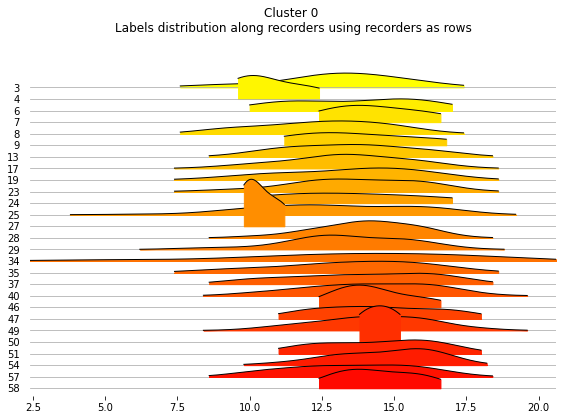

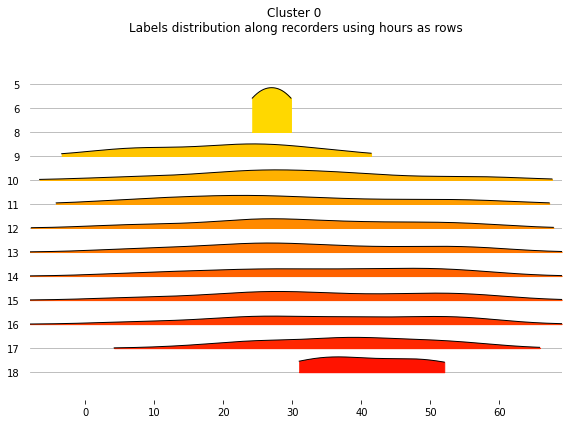

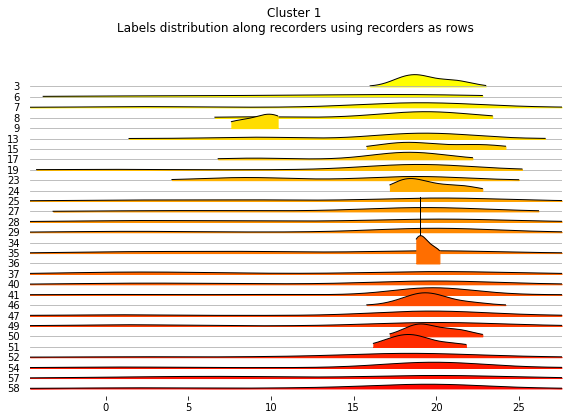

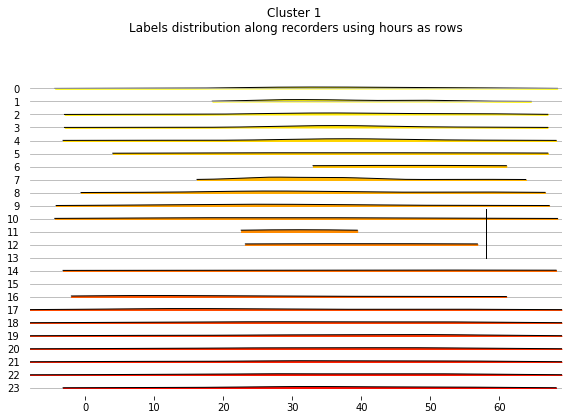

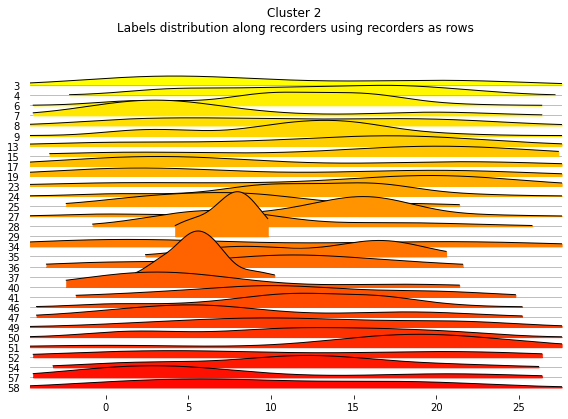

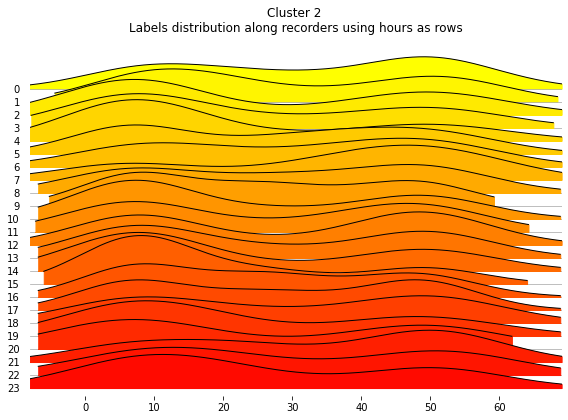

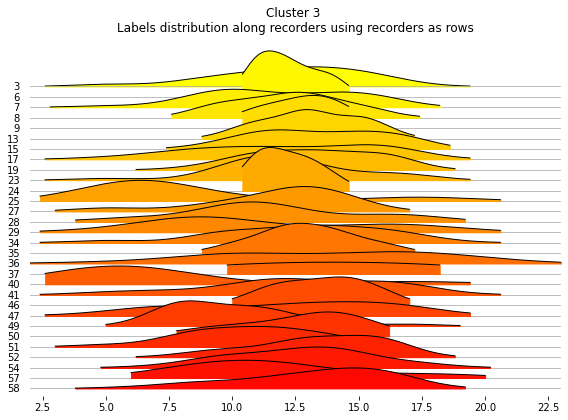

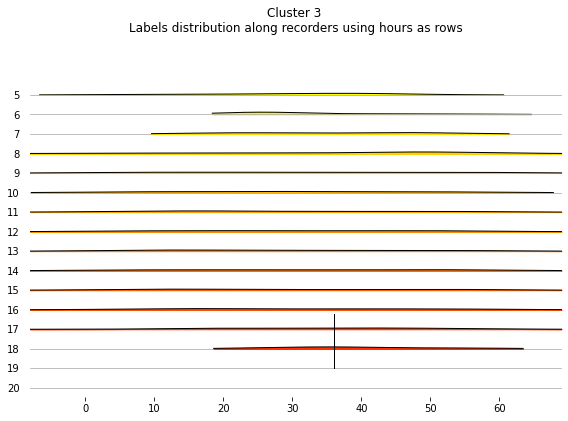

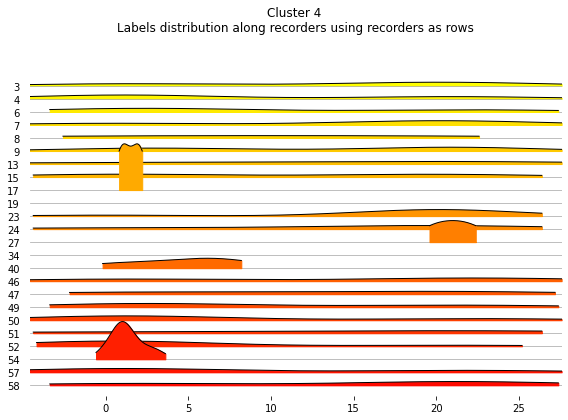

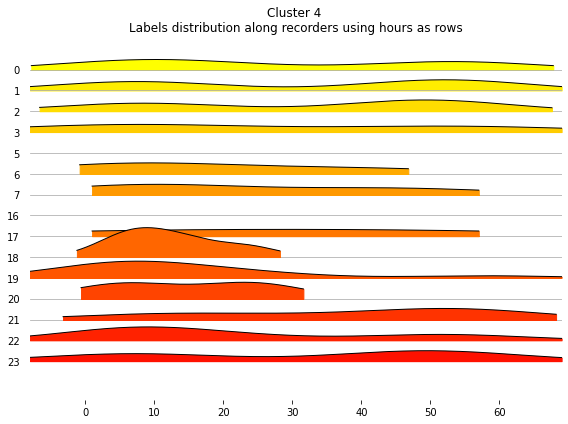

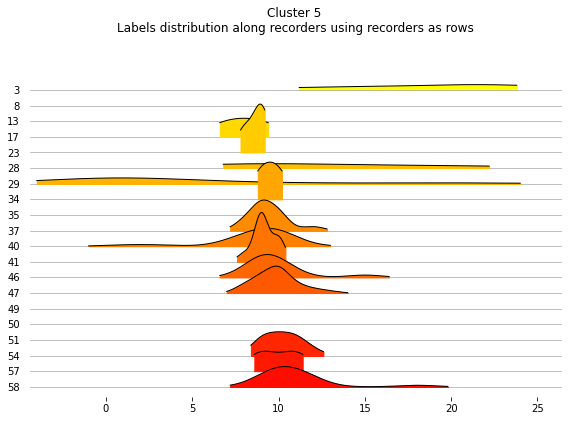

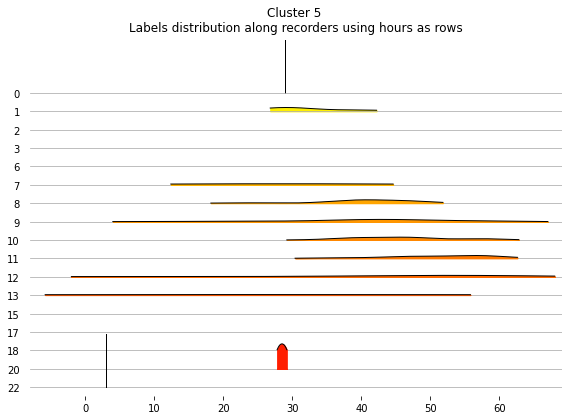

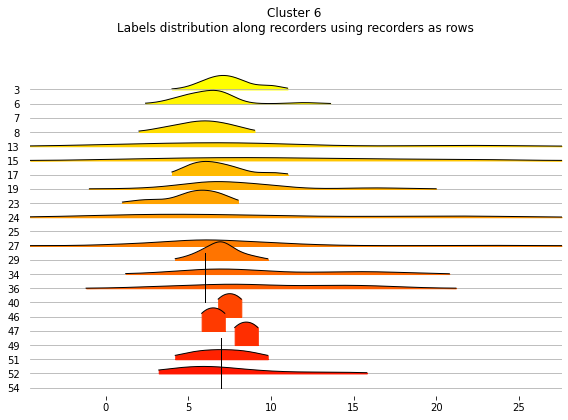

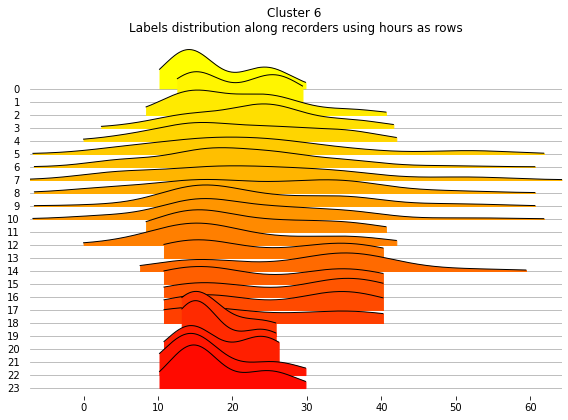

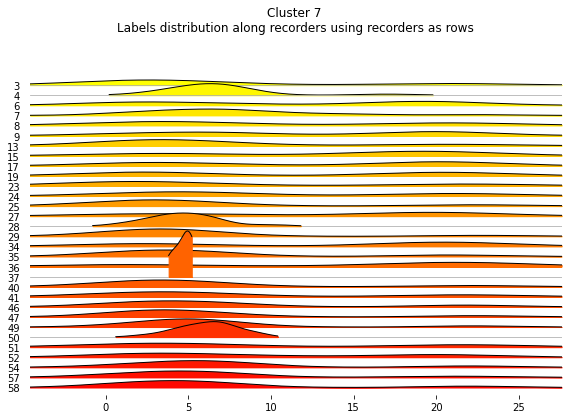

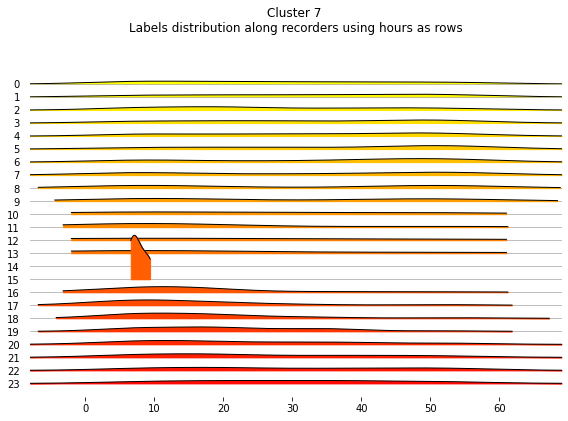

In [34]:
# from sklearn.cluster import KMeans
# Kmeans = KMeans(n_clusters=8, random_state=0).fit(X_scaled)
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="recorder", hist_library="plt")
Kmeans_Results.joyplot()

In [ ]:
def converter(var):
        aux = []
        for i in range(len(var)):
            aux.append(var[i].item())
        return np.array(aux)
y_n = converter(y["hour"])[0:6000]
y_n

array([10,  3, 16, ..., 22, 10,  0])

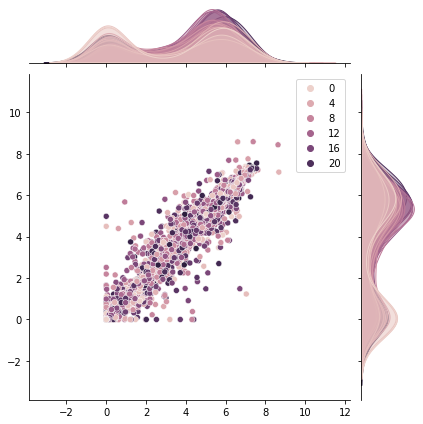

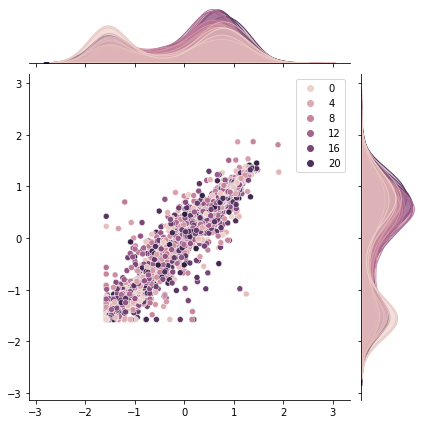

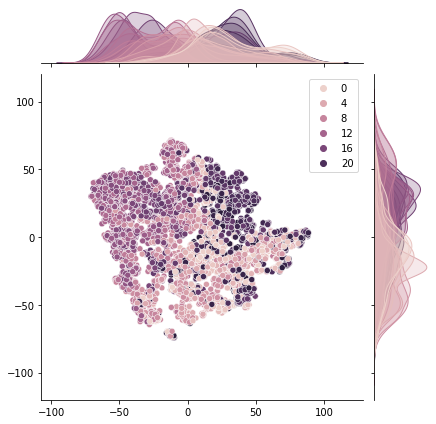

In [ ]:
X_n = X.numpy()
X_ = [X_n, X_scaled, X_TSNE]
# fig, axes = plt.subplots(1, 3, figsize=(16, 6))
for enum, x in enumerate(X_):
    sns.jointplot(x=X_[enum][:,0], y= X_[enum][:,1], hue=y_n[0:6000]) 

In [ ]:
list(Kmeans_Results.one_cluster_eval(0)).count(2)

187

In [ ]:
import warnings
warnings.filterwarnings("ignore")
Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
Kmeans_Results.histograms()

NameError: ignored

## Kmeans

In [35]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
mean = X.mean()
std = X.std()
silhouette_score_Kmeans = []
# X_normalized = 
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_scaled)
    silhouette_score_Kmeans.append(metrics.silhouette_score(X_scaled, Kmeans.labels_))
    plot_silhouette(X_scaled, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id], "Kmeans")
    cluster_centers = scaler.inverse_transform(Kmeans.cluster_centers_)
    plot_centroids(cluster_centers, testing, "Kmeans")
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
    Kmeans_Results.joyplot()
with open(f"Clustering_Results/Kmeans/Results/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(silhouette_score_Kmeans, file)

Output hidden; open in https://colab.research.google.com to view.

## Kmeans TSNE


In [38]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_embedded_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_scaled)

mean = X.mean()
std = X.std()
silhouette_score_Kmeans = []
# X_normalized = 
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_embedded_TSNE)
    silhouette_score_Kmeans.append(metrics.silhouette_score(X_embedded_TSNE, Kmeans.labels_))
    plot_silhouette(X_embedded_TSNE, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id], "Kmeans_TSNE")
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
    Kmeans_Results.joyplot()
    # cluster_centers = scaler.inverse_transform(Kmeans.cluster_centers_)
    # plot_centroids(cluster_centers, testing, "Kmeans_TSNE")
with open(f"Clustering_Results/Kmeans_TSNE/Results/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(silhouette_score_Kmeans, file)

Output hidden; open in https://colab.research.google.com to view.

## Kmeans PCA


Text(0, 0.5, 'Cummulative Explained Variance ')

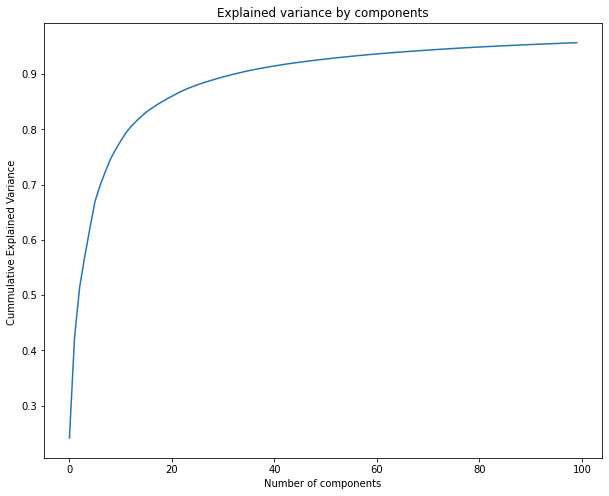

In [37]:
from sklearn.decomposition import PCA
n_components = 100
plt.figure(figsize=(10,8))
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_PCA = PCA(n_components=n_components).fit(X_scaled)
plt.plot(range(0, n_components), X_PCA.explained_variance_ratio_.cumsum())
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cummulative Explained Variance ")

In [39]:
from sklearn.decomposition import PCA
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_embedded_PCA = PCA(n_components=40).fit_transform(X_scaled)

mean = X.mean()
std = X.std()
silhouette_score_Kmeans = []
# X_normalized = 
for id, n_cluster in enumerate(clusters):
    Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_embedded_PCA)
    silhouette_score_Kmeans.append(metrics.silhouette_score(X_embedded_PCA, Kmeans.labels_))
    plot_silhouette(X_embedded_PCA, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id], "Kmeans_PCA")
    Kmeans_Results = Clustering_Results(Kmeans, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
    Kmeans_Results.joyplot()
    # cluster_centers = scaler.inverse_transform(Kmeans.cluster_centers_)
    # plot_centroids(cluster_centers, testing, "Kmeans_TSNE")
with open(f"Clustering_Results/Kmeans_PCA/Results/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
    pkl.dump(silhouette_score_Kmeans, file)

Output hidden; open in https://colab.research.google.com to view.

## DBSCAN

0.01
1 1
Entra


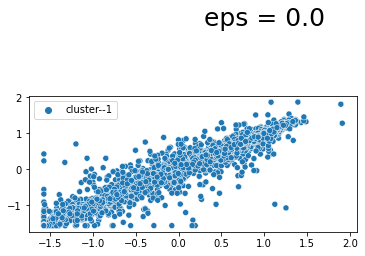

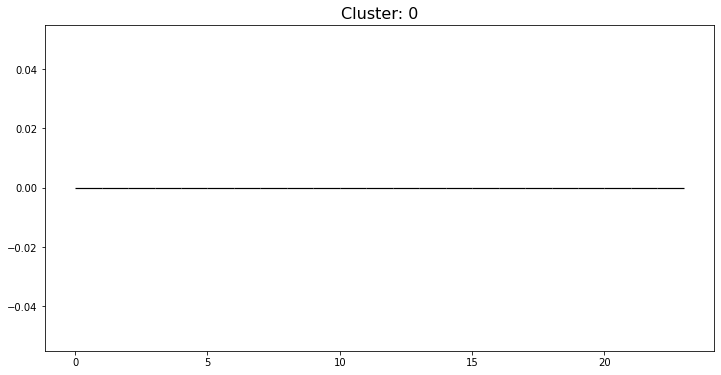

Estimated number of clusters: 0
Estimated number of noise points: 6000
0.1
1 1
Entra


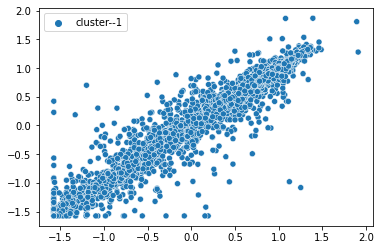

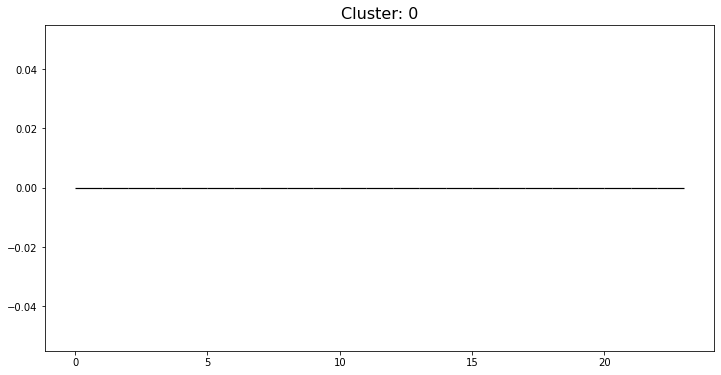

Estimated number of clusters: 0
Estimated number of noise points: 6000
0.5
1 1
Entra


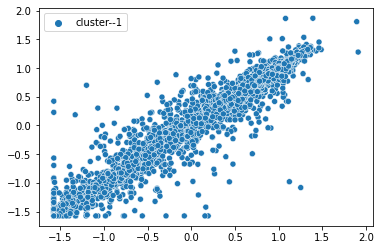

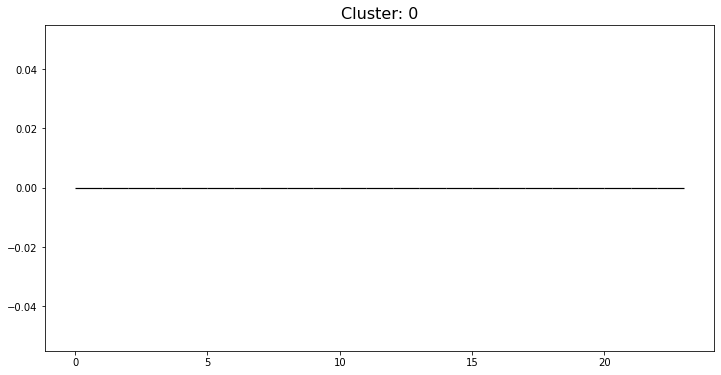

Estimated number of clusters: 0
Estimated number of noise points: 6000
1
1 1
Entra


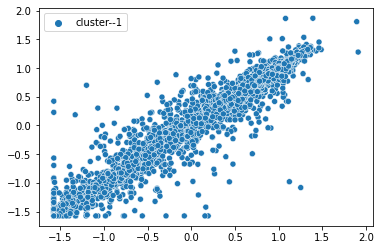

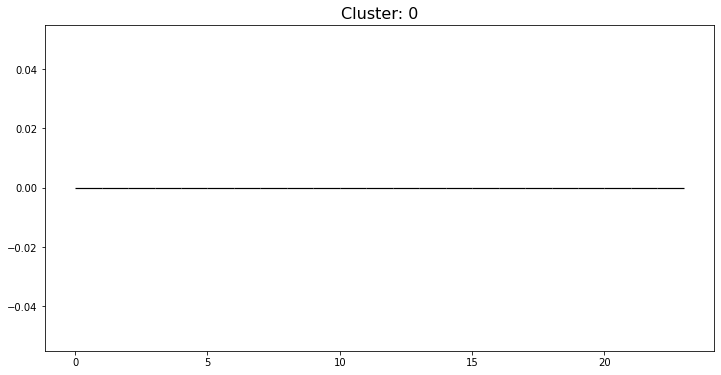

Estimated number of clusters: 0
Estimated number of noise points: 6000
10
3 3


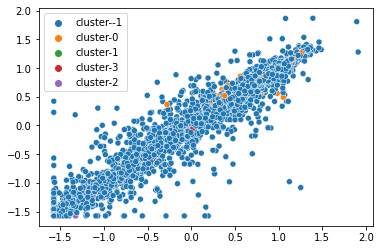

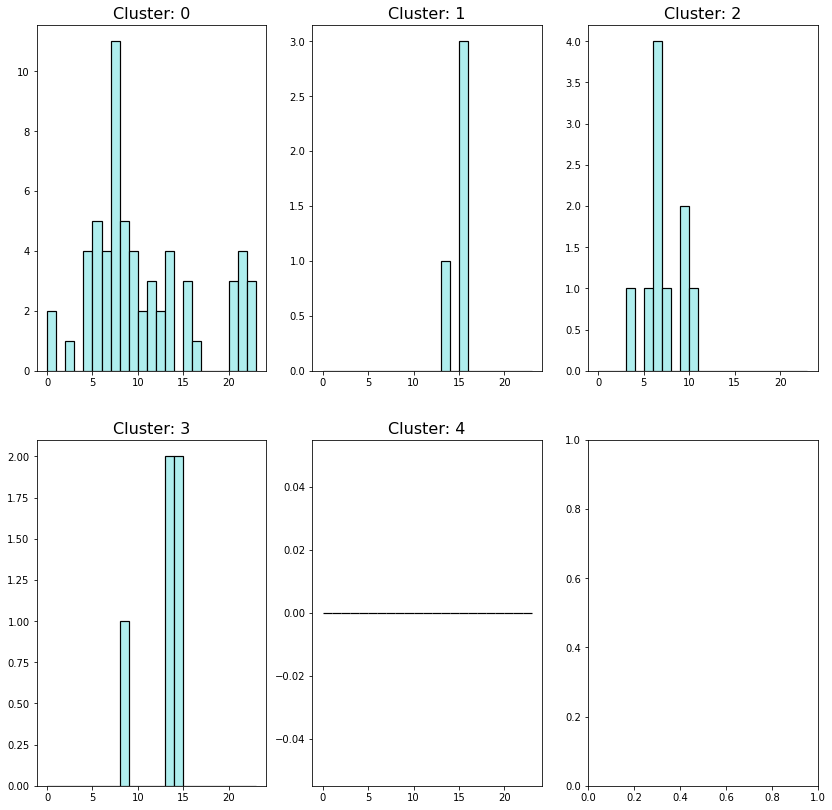

Estimated number of clusters: 4
Estimated number of noise points: 5920
20
8 8


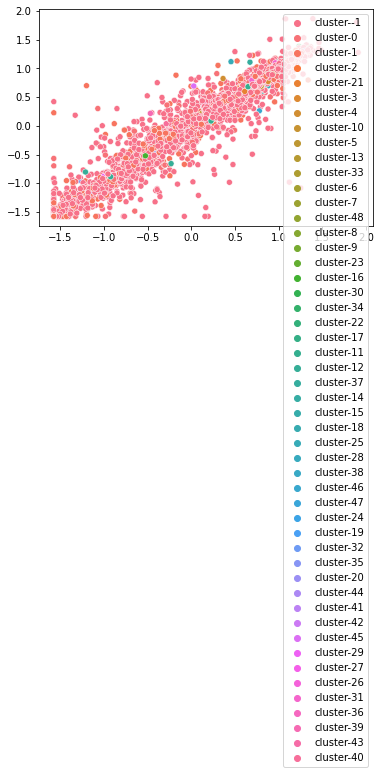

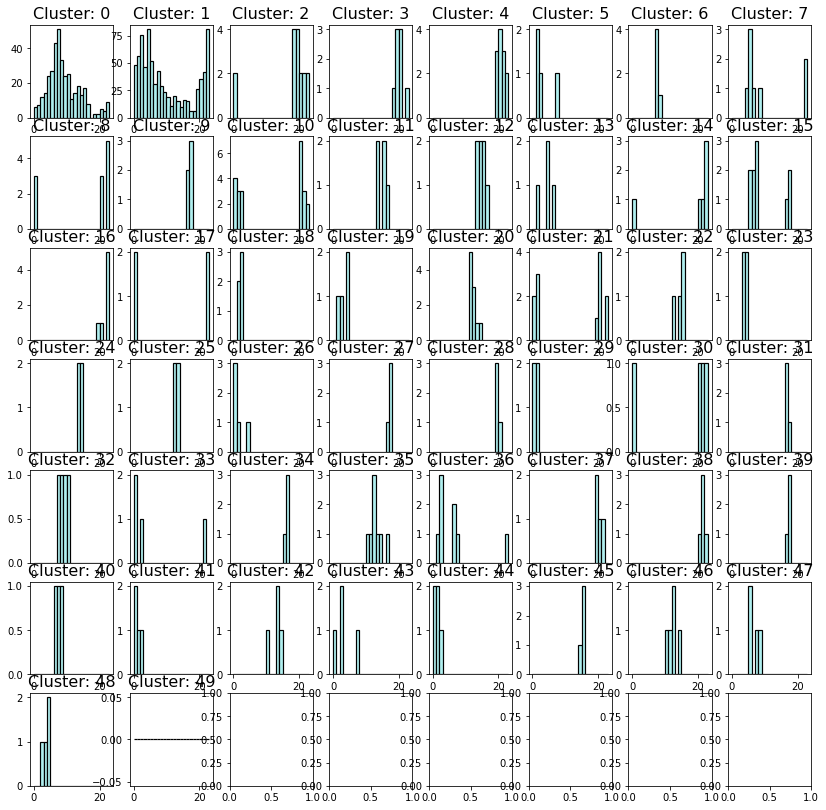

Estimated number of clusters: 49
Estimated number of noise points: 4560
36
5 5


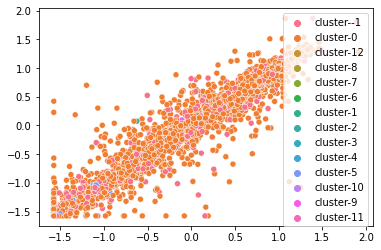

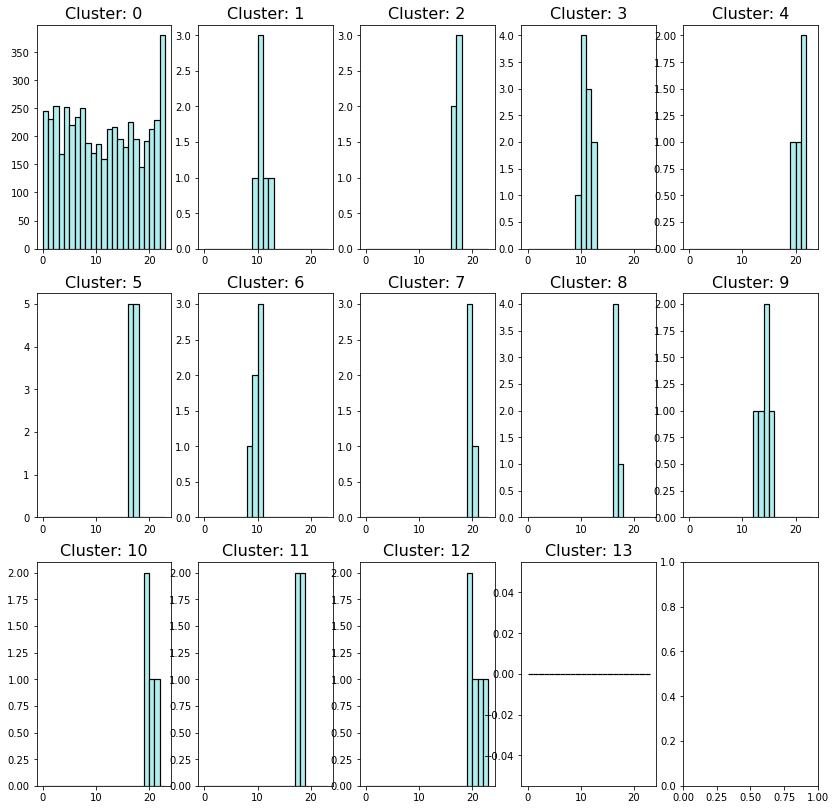

Estimated number of clusters: 13
Estimated number of noise points: 982
50
2 2
Entra


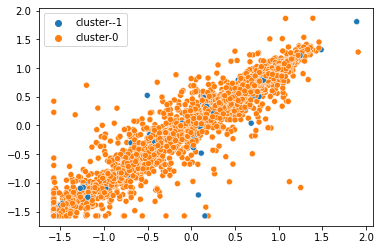

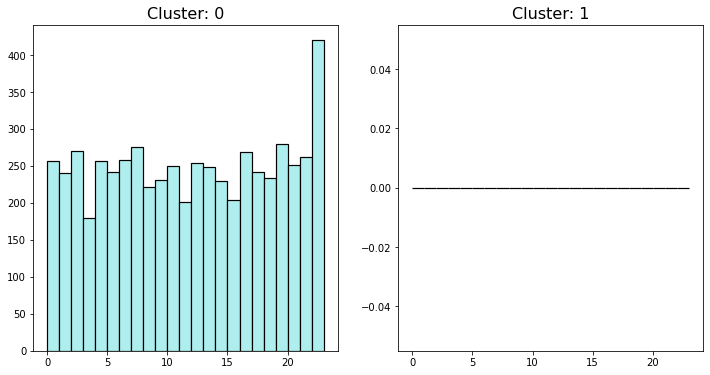

Estimated number of clusters: 1
Estimated number of noise points: 226
80
2 2
Entra


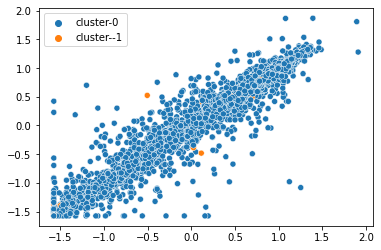

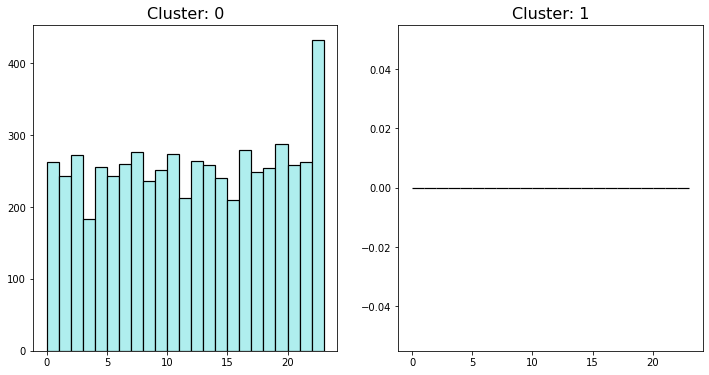

Estimated number of clusters: 1
Estimated number of noise points: 35


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

X_scaled = StandardScaler().fit_transform(X)
X_PCA = PCA(n_components=40).fit_transform(X_scaled)

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
classes = []
silhouette_score_DBSCAN = []
i = 1
EPS = [0.01, 0.1, 0.5, 1, 10, 20, 36, 50, 80, 100]
for x in range(0, 9, 1):
    eps = EPS[x]
    db = DBSCAN(eps=eps, min_samples=4).fit(X_scaled)
    # silhouette_score_DBSCAN.append(metrics.silhouette_score(X_PCA, db.labels_))
    # plot_silhouette(X_PCA, db.labels_, 15, silhouette_score_DBSCAN[i-1], "DBSCAN_PCA")
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(3, 3, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_scaled[:,0], X_scaled[:,1], hue=["cluster-{}".format(x) for x in labels]) 
    i += 1

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    Kmeans_Results = Clustering_Results(db, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
with open(f"Clustering_Results/DBSCAN/Results/silhouette_n-clusters_{n_clusters_}", "wb") as file:
    pkl.dump(silhouette_score_DBSCAN, file)


In [ ]:
db = DBSCAN(eps=36, min_samples=4).fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 13
Estimated number of noise points: 982


## DBSCAN PCA

0.01
Estimated number of clusters: 0
Estimated number of noise points: 6000
1 1
Entra


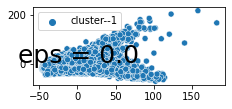

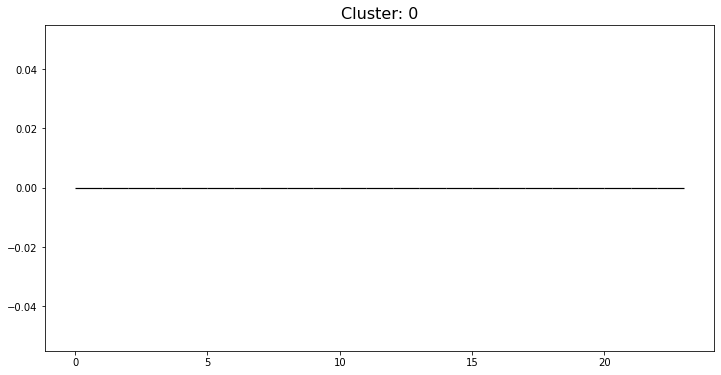

0.1
Estimated number of clusters: 0
Estimated number of noise points: 6000
1 1
Entra


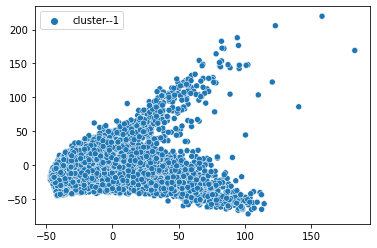

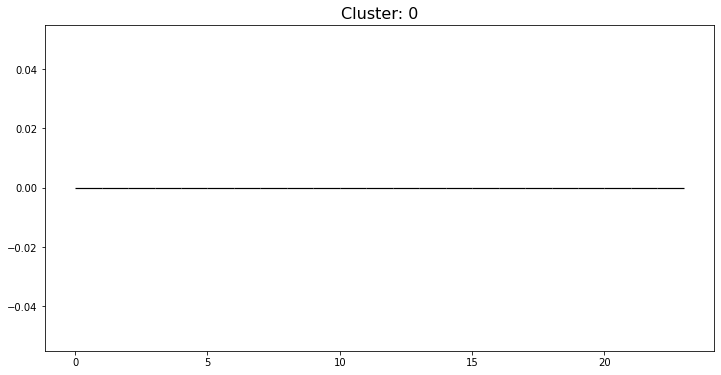

0.5
Estimated number of clusters: 0
Estimated number of noise points: 6000
1 1
Entra


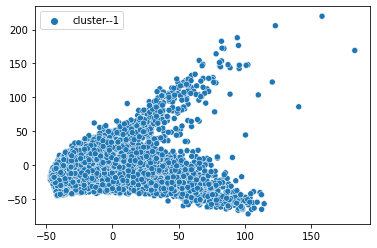

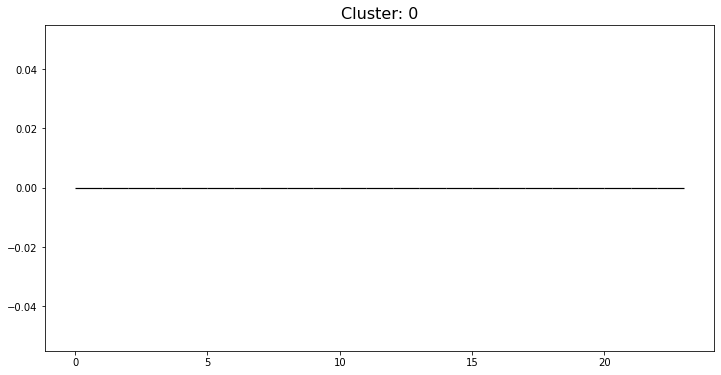

1
Estimated number of clusters: 0
Estimated number of noise points: 6000
1 1
Entra


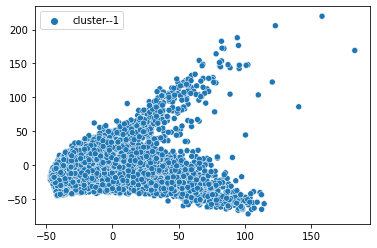

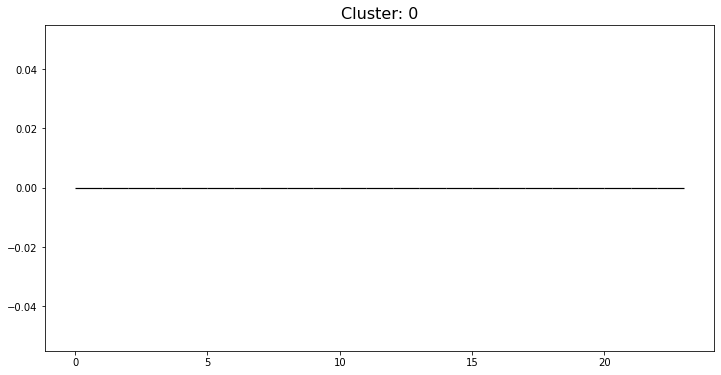

10
Estimated number of clusters: 48
Estimated number of noise points: 5407
7 7


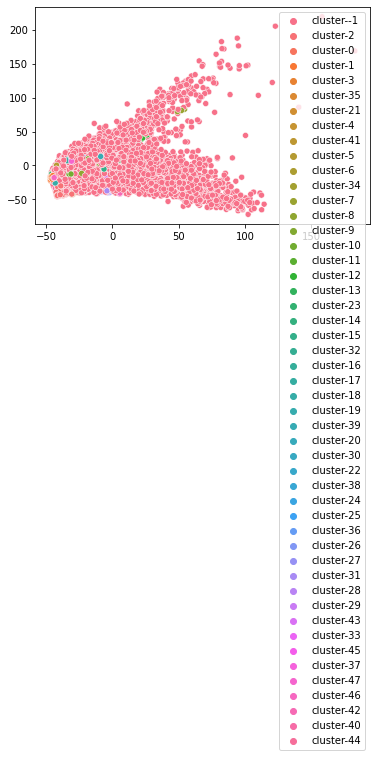

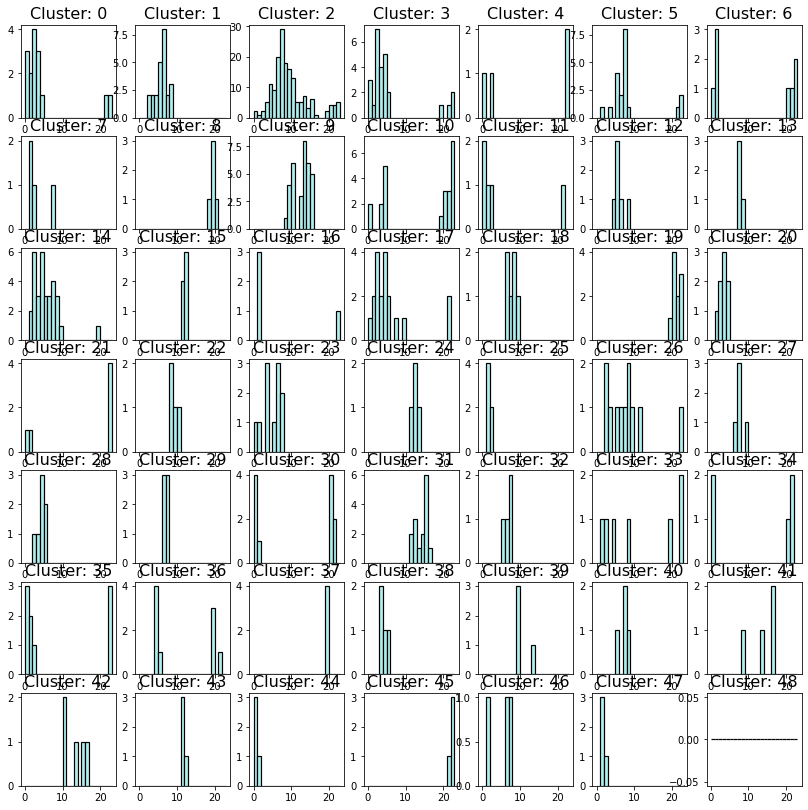

20
Estimated number of clusters: 49
Estimated number of noise points: 2082
8 8


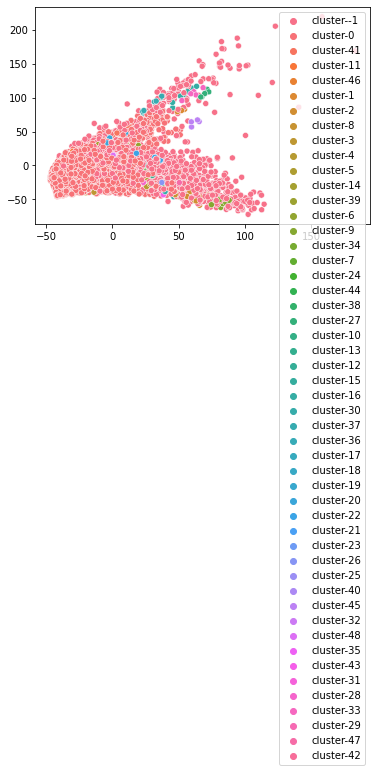

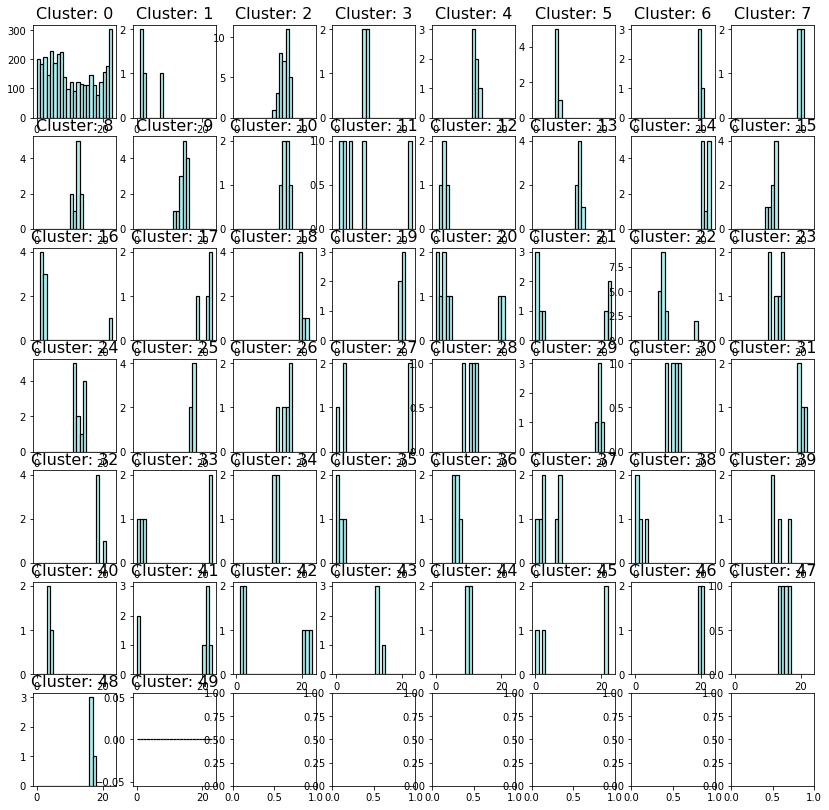

36
Estimated number of clusters: 5
Estimated number of noise points: 210
3 3


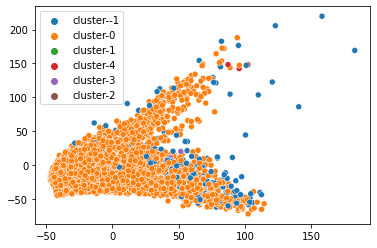

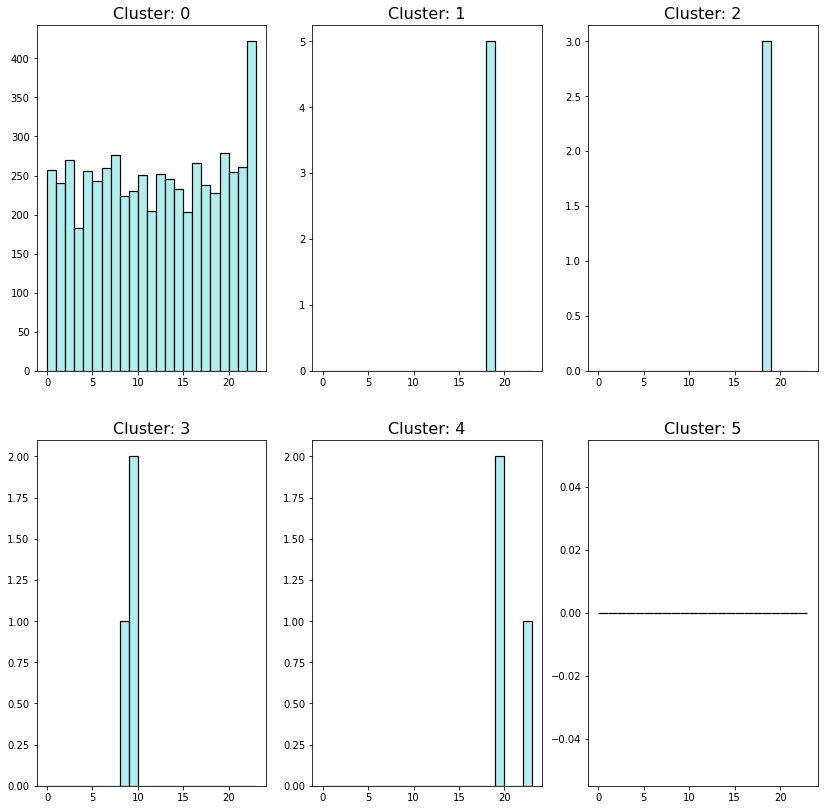

50
Estimated number of clusters: 1
Estimated number of noise points: 63
2 2
Entra


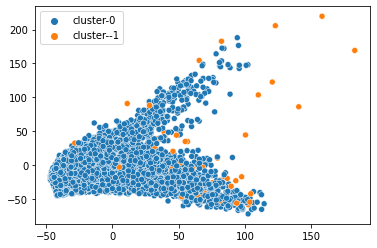

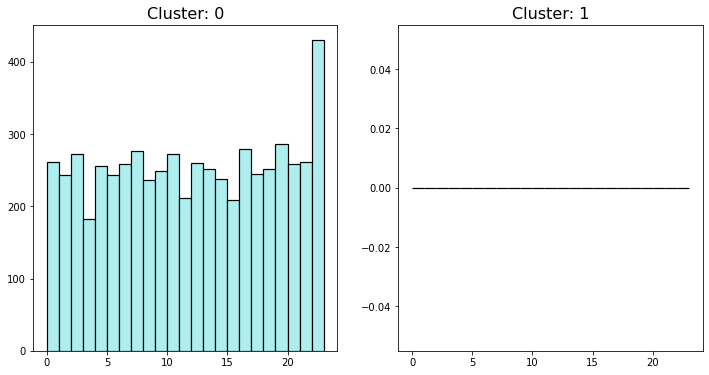

80
Estimated number of clusters: 1
Estimated number of noise points: 7
2 2
Entra


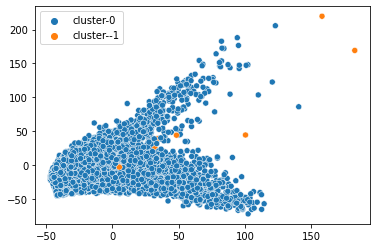

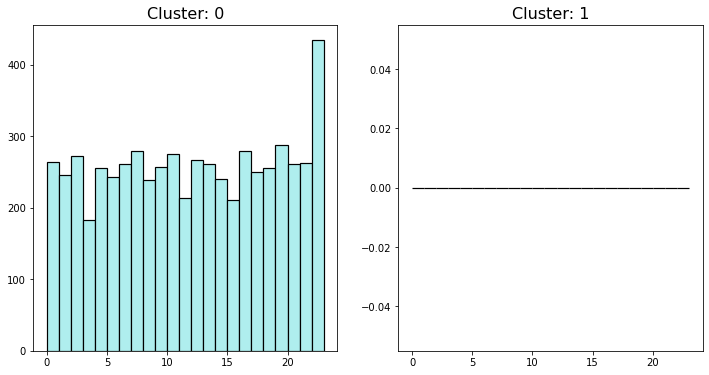

In [ ]:
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

X_scaled = StandardScaler().fit_transform(X)
X_PCA = PCA(n_components=40).fit_transform(X_scaled)

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
classes = []
silhouette_score_DBSCAN = []
i = 1
EPS = [0.01, 0.1, 0.5, 1, 10, 20, 36, 50, 80, 100]
for x in range(0, 9, 1):
    eps = EPS[x]
    db = DBSCAN(eps=eps, min_samples=4).fit(X_PCA)
    # silhouette_score_DBSCAN.append(metrics.silhouette_score(X_PCA, db.labels_))
    # plot_silhouette(X_PCA, db.labels_, 15, silhouette_score_DBSCAN[i-1], "DBSCAN_PCA")
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(5, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=["cluster-{}".format(x) for x in labels]) 
    i += 1

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    Kmeans_Results = Clustering_Results(db, y, y_label="hour", hist_library="plt")
    Kmeans_Results.histograms()
with open(f"Clustering_Results/DBSCAN_PCA/Results/silhouette_n-clusters_{n_clusters_}", "wb") as file:
    pkl.dump(silhouette_score_DBSCAN, file)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The knee is located at: 328.07470703125


<Figure size 360x360 with 0 Axes>

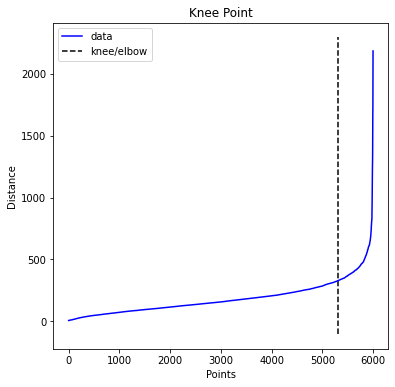

In [ ]:
!pip install kneed
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=10)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,9], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig2 = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(f"The knee is located at: {distances[knee.knee]}")

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=12,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=1,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
linkage = "complete"
connectivity = False
model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, 
                n_clusters=3)
model.fit(X_PCA)

ValueError: ignored

In [40]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],
#                   [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X_scaled)
n_clusters_ = len(set(clustering.labels_))
print(n_clusters_)
print(list(clustering.labels_).count(0))

2
3114


In [ ]:
print(list(clustering.labels_).count(1))

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

In [ ]:
import seaborn as sns; sns.set()
import pandas as pd

import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

get_best_distribution(X[540,:])

p value for norm = 2.269828405412093e-303
p value for exponweib = 0.0
p value for weibull_max = 1.3008152726066972e-191
p value for weibull_min = 0.0
p value for pareto = 0.0
p value for genextreme = 0.0
Best fitting distribution: weibull_max
Best p value: 1.3008152726066972e-191
Parameters for the best fit: (44075.20374348934, 298825.6207744933, 298822.1909931941)


('weibull_max',
 1.3008152726066972e-191,
 (44075.20374348934, 298825.6207744933, 298822.1909931941))

In [ ]:
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X)

NameError: ignored